**Step 1: Import Libraries**

We start by importing the necessary Python libraries for data manipulation, visualization, and machine learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE  

**Step 2: Load the Dataset**

Load the dataset into a Pandas DataFrame. 

In [2]:
# Load the training dataset
train_data = pd.read_csv('fraudTrain.csv') 

# Load the testing dataset
test_data = pd.read_csv('fraudTest.csv')

# Display the first few rows of both datasets
print("First 5 rows of the training dataset:")
print(train_data.head())

print("\nFirst 5 rows of the testing dataset:")
print(test_data.head())

First 5 rows of the training dataset:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F 

**Step 3: Exploratory Data Analysis (EDA)**

Perform basic exploratory analysis to understand the dataset.

In [3]:
print("\nData Description of training dataset:")
print(train_data.describe(include = 'all').T)



Data Description of training dataset:
                           count   unique                               top  \
Unnamed: 0             1296675.0      NaN                               NaN   
trans_date_trans_time    1296675  1274791               2019-04-22 16:02:01   
cc_num                 1296675.0      NaN                               NaN   
merchant                 1296675      693                 fraud_Kilback LLC   
category                 1296675       14                     gas_transport   
amt                    1296675.0      NaN                               NaN   
first                    1296675      352                       Christopher   
last                     1296675      481                             Smith   
gender                   1296675        2                                 F   
street                   1296675      983        0069 Robin Brooks Apt. 695   
city                     1296675      894                        Birmingham   
state        


Missing values in the training dataset:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

Summary statistics for numeric columns in the training dataset:
         Unnamed: 0        cc_num           amt           zip           lat  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean   6.483370e+05  4.171920e+17  7.035104e+01  4.880067e+04  3.853762e+01   
std    3.743180e+05  1.

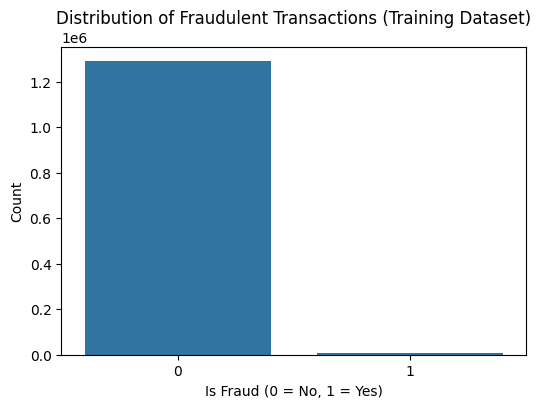

In [4]:
# Check for missing values in the training dataset
print("\nMissing values in the training dataset:")
print(train_data.isnull().sum())

# Summary statistics for numeric columns
print("\nSummary statistics for numeric columns in the training dataset:")
print(train_data.describe())

# Distribution of the target variable ('is_fraud') in the training dataset
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=train_data)
plt.title('Distribution of Fraudulent Transactions (Training Dataset)')
plt.xlabel('Is Fraud (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

**Step 4: Correlation Heatmap**

Compute and visualize the correlation matrix for both categorical and numeric columns.

Text(0.5, 1.0, 'Correlation Heatmap (Categorical vs. Numerical)')

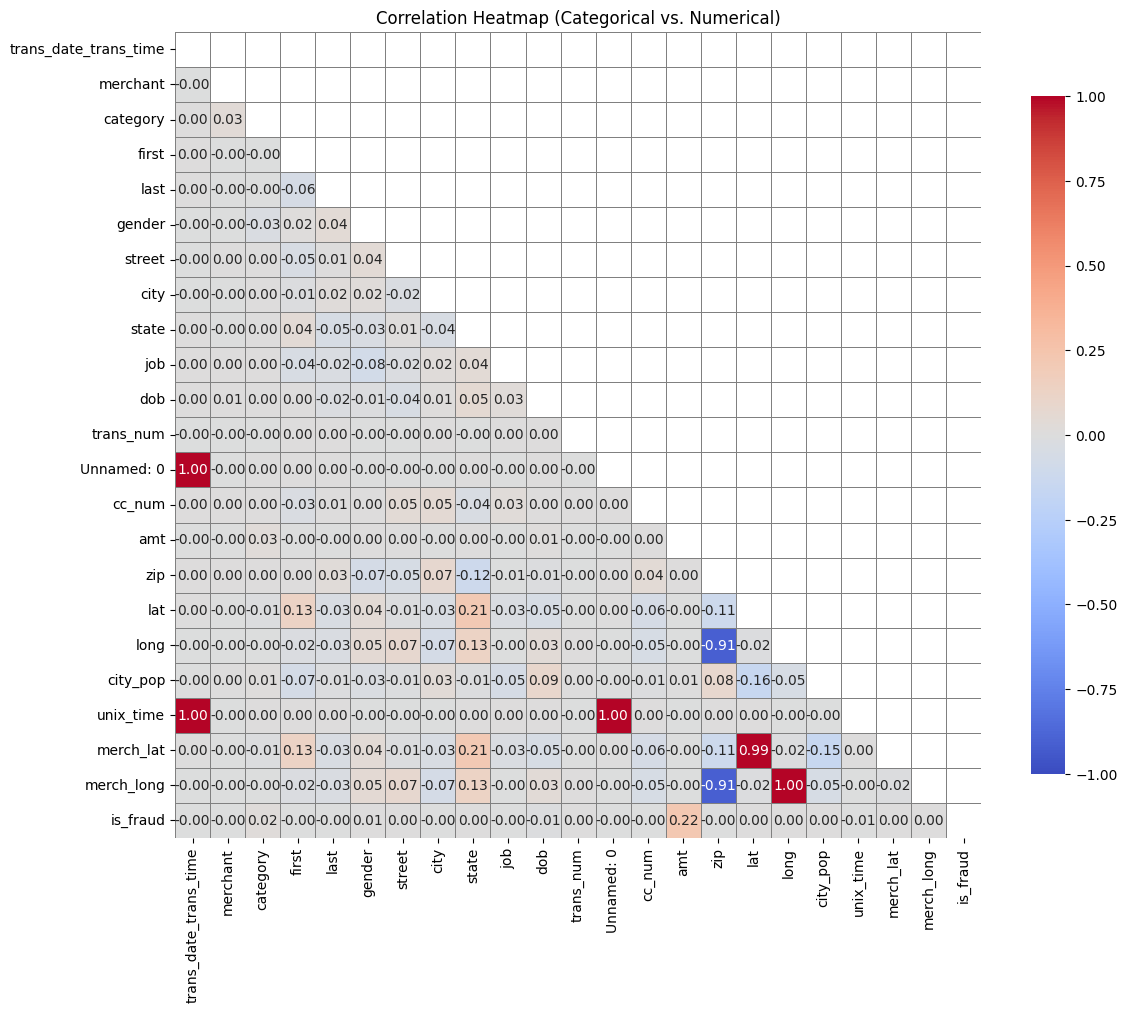

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select categorical and numerical columns for the heatmap
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()   # Example categorical columns, replace with your actual columns
numerical_cols = train_data.select_dtypes(include=[np.number]).columns.tolist() # Example numerical columns, replace with your actual columns

# Convert categorical columns to numerical using label encoding (you can use other methods if needed)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_encoded = train_data.copy()  # Create a copy to avoid modifying the original DataFrame

for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Select the encoded categorical columns and the numerical columns for correlation
df_heatmap = df_encoded[categorical_cols + numerical_cols]


# Compute the correlation matrix
correlation_matrix = df_heatmap.corr()

# Mask the upper triangle of the matrix to avoid duplication in visualization
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(13, 11))

# Create the heatmap with the mask and a color palette
sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            mask=mask,  # Apply the mask to hide the upper triangle
            square=True,
            cbar_kws={"shrink": .8},
            linewidths=.5,  # Add lines between cells
            linecolor='gray',  # Color of the lines
            vmin=-1, vmax=1)  # Set limits for color scale

# Set title
plt.title("Correlation Heatmap (Categorical vs. Numerical)")

**Step 5: Feature Engineering**

Prepare the dataset for modeling by encoding categorical variables, scaling numerical features, and handling missing values.

In [6]:
# Drop unnecessary columns (only include columns that exist in the dataset)
columns_to_drop = ['Unnamed: 0', 'trans_num', 'unix_time', 'first', 'last', 'long', 'lat']
train_data.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')

# Define features (X) and target (y) for the training dataset
X_train = train_data.drop('is_fraud', axis=1)  # Features (all columns except 'is_fraud')
y_train = train_data['is_fraud']  # Target variable ('is_fraud')

# Define features (X) and target (y) for the testing dataset
X_test = test_data.drop('is_fraud', axis=1)  # Features (all columns except 'is_fraud')
y_test = test_data['is_fraud']  # Target variable ('is_fraud')

# Dynamically identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Convert 'trans_date_trans_time' to datetime and extract features
if 'trans_date_trans_time' in X_train.columns:
    # Convert 'trans_date_trans_time' to datetime format
    X_train['trans_date_trans_time'] = pd.to_datetime(X_train['trans_date_trans_time'])
    X_test['trans_date_trans_time'] = pd.to_datetime(X_test['trans_date_trans_time'])

    # Extract useful features from 'trans_date_trans_time'
    X_train['hour'] = X_train['trans_date_trans_time'].dt.hour
    X_train['day'] = X_train['trans_date_trans_time'].dt.day
    X_train['month'] = X_train['trans_date_trans_time'].dt.month
    X_train['day_of_week'] = X_train['trans_date_trans_time'].dt.dayofweek

    X_test['hour'] = X_test['trans_date_trans_time'].dt.hour
    X_test['day'] = X_test['trans_date_trans_time'].dt.day
    X_test['month'] = X_test['trans_date_trans_time'].dt.month
    X_test['day_of_week'] = X_test['trans_date_trans_time'].dt.dayofweek

    # Drop the original 'trans_date_trans_time' column
    X_train.drop('trans_date_trans_time', axis=1, inplace=True, errors='ignore')
    X_test.drop('trans_date_trans_time', axis=1, inplace=True, errors='ignore')

    # Update categorical and numerical columns after preprocessing
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Encode categorical variables using LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_cols:
    # Fit LabelEncoder on the union of train and test data to avoid unseen labels
    combined = pd.concat([X_train[col], X_test[col]])
    label_encoder.fit(combined)

    # Transform both train and test data
    X_train[col] = label_encoder.transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])

# Scale numerical features using StandardScaler
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])  # Use transform (not fit_transform) for test data

# Ensure X_train and X_test have the same columns
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# Print the final set of columns to verify
print("Final set of columns in X_train and X_test:")
print(X_train.columns)

Final set of columns in X_train and X_test:
Index(['cc_num', 'merchant', 'category', 'amt', 'gender', 'street', 'city',
       'state', 'zip', 'city_pop', 'job', 'dob', 'merch_lat', 'merch_long',
       'hour', 'day', 'month', 'day_of_week'],
      dtype='object')


**Step 6: Train & Evaluate the model**

a) Train a AdaBoostClassifier on the training data. <br>
b) Evaluate the performance of the model using metrics like accuracy, precision, recall, and F1-score. <br>



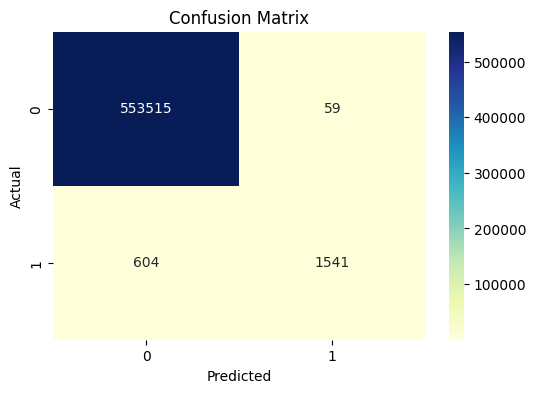

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.96      0.72      0.82      2145

    accuracy                           1.00    555719
   macro avg       0.98      0.86      0.91    555719
weighted avg       1.00      1.00      1.00    555719

Accuracy Score: 99.88069509950172


In [7]:
from xgboost import XGBClassifier

XGB = XGBClassifier(n_estimators = 300, max_depth = 30, learning_rate = 0.005)
XGB.fit(X_train,y_train)
XGB_preds = XGB.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, XGB_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy score
accuracy = accuracy_score(y_test , XGB_preds)

print('Classification Report:\n',classification_report(y_test , XGB_preds))
print('Accuracy Score:',accuracy_score(y_test, XGB_preds)*100)

**Step 7: Feature Importance**

Analyze which features are most important for detecting fraud.


Feature Importance:
        Feature  Importance
3           amt    0.401441
14         hour    0.239325
2      category    0.201897
11          dob    0.041291
4        gender    0.039134
9      city_pop    0.013860
16        month    0.006464
17  day_of_week    0.006239
0        cc_num    0.005765
15          day    0.005563
6          city    0.005272
8           zip    0.005239
7         state    0.005162
5        street    0.005148
12    merch_lat    0.004830
13   merch_long    0.004680
10          job    0.004662
1      merchant    0.004028


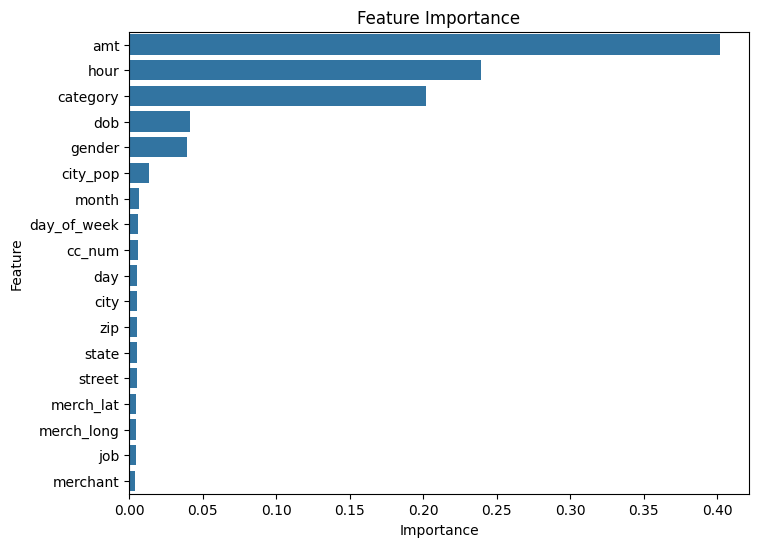

In [8]:
# Extract feature importance from the trained model
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': XGB.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print feature importance
print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

Filtered predicted fraud records


In [10]:
# Add predictions to the test dataset
test_data['predicted_is_fraud'] = XGB_preds 

# Filter records predicted as fraud
predicted_fraud_records = test_data[test_data['predicted_is_fraud'] == 1]

# Display the filtered records
print("\nRecords Predicted as Fraud:")
print(predicted_fraud_records)

# Save the fraud records to a CSV file
predicted_fraud_records.to_csv('predicted_fraud_records.csv', index=False)

print("\nFraud records saved to 'predicted_fraud_records.csv'")


Records Predicted as Fraud:
       trans_date_trans_time            cc_num  \
1767     2020-06-21 22:32:22  6564459919350820   
1781     2020-06-21 22:37:27  6564459919350820   
1784     2020-06-21 22:38:55  4005676619255478   
1857     2020-06-21 23:02:16  3560725013359375   
1906     2020-06-21 23:21:44  4005676619255478   
...                      ...               ...   
517274   2020-12-22 22:18:07  2242176657877538   
517341   2020-12-22 22:31:48  2242176657877538   
517529   2020-12-22 23:06:03  2242176657877538   
517571   2020-12-22 23:13:39  2242176657877538   
524263   2020-12-25 01:50:25  3595192916105588   

                                   merchant       category      amt gender  \
1767      fraud_Rodriguez, Yost and Jenkins       misc_net   780.52      M   
1781                       fraud_Nienow PLC  entertainment   620.33      M   
1784    fraud_Heathcote, Yost and Kertzmann   shopping_net  1077.69      M   
1857                 fraud_Hermann and Sons   shopping_pos

Visualize the Predicted Fraud records

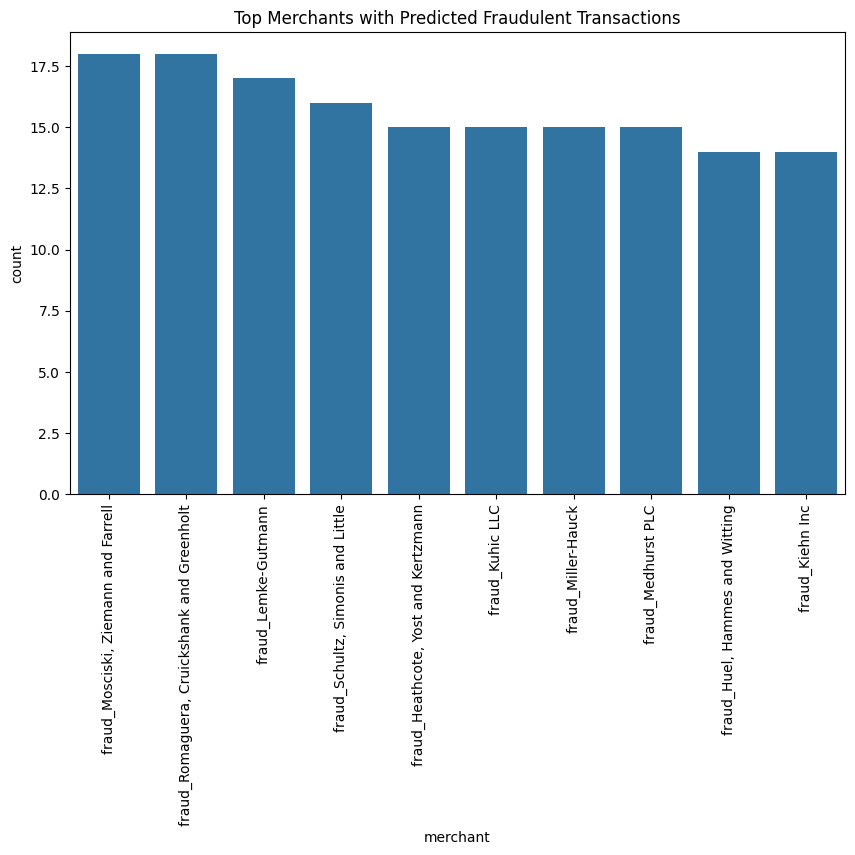

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=predicted_fraud_records, x='merchant', order=predicted_fraud_records['merchant'].value_counts().index[:10])
plt.title('Top Merchants with Predicted Fraudulent Transactions')
plt.xticks(rotation=90)
plt.show()

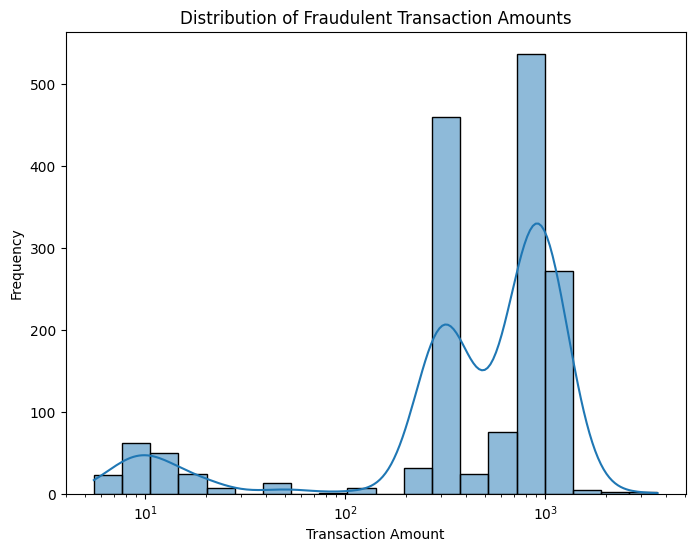

In [12]:
# Fraud Amount Distribution
plt.figure(figsize=(8, 6))
sns.histplot(predicted_fraud_records['amt'], bins=20, kde=True, log_scale=True)
plt.title('Distribution of Fraudulent Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()